Import packages

In [43]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime as dt
from scipy.optimize import minimize
import zipfile
import matplotlib.pyplot as plt
# %matplotlib inline

In [44]:
CALCULATE_STD = False

#### Download ticker list and prices:

In [45]:
zf = zipfile.ZipFile('archive.zip') 

tickers = pd.read_csv(zf.open('ticker_info.csv'), engine="pyarrow")
stocks = pd.read_csv(zf.open('stock_data.csv'), index_col='date', engine="pyarrow")

tickers = tickers['ticker']
stocks = stocks[['ticker', 'close', 'volume']]

stocks.index = pd.to_datetime(stocks.index)

In [46]:
stocks = stocks[stocks.index > pd.to_datetime('2011-01-01')]

Choose 1% lowest volatility stocks:

In [47]:
if CALCULATE_STD:
   stdev = []

   t1 = dt.datetime.now().timestamp()

   for ticker in tickers[:1000]:
      asset = stocks[stocks.ticker==ticker]['close']
      stdev.append(asset.pct_change()[1:].std())

   t2 = dt.datetime.now().timestamp()

   print('Processing time:', t2 - t1)
   df = pd.DataFrame(np.array(stdev), tickers[:1000].values, columns=['stdev'])
   df = df.dropna()

   df.to_csv('stdev.csv')

else:

   df =  pd.read_csv('stdev.csv')
   q = df.stdev.quantile(0.01)

   df['ticker'] = df['Unnamed: 0']
   del df['Unnamed: 0']
   df.index = df['ticker']
   del df['ticker']

   df = df[df.stdev < q]
   df = pd.Series(df.stdev, df.index)

Select stocks listed before 2011:

In [48]:
to_drop = []

for ticker in df.index:
    p = stocks[stocks.ticker==ticker]['close']
    if len(p.values) < 2753:
        to_drop.append(ticker)

df = df.drop(labels = to_drop)

In [49]:
template = []

start = pd.to_datetime('2011-01-04')
end = pd.to_datetime('2022-05-11')

for i in range(len(df)):
    p = stocks[stocks.ticker==df.index[i]]['close']
    if start in p.index:
        p = p[start:end]
        template.append(p)

In [50]:
data = pd.DataFrame(index = p.index)
data['p1'] = template[0].values
data['p2'] = template[1].values
data['p3'] = template[2].values
data['p4'] = template[3].values

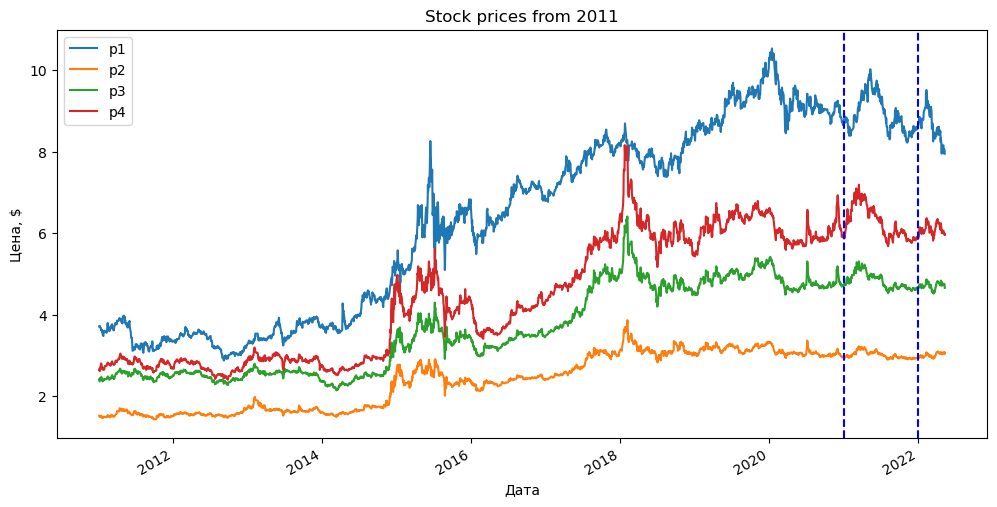

In [51]:
data.plot(figsize=(12,6), title='Stock prices from 2011', xlabel='Дата', ylabel='Цена, $')
plt.axvline("2021-01-01", color="blue", linestyle="--", label = "2021-01-01")
plt.axvline("2022-01-01", color="blue", linestyle="--", label = "2021-01-01")
plt.show()

In [52]:
def SMA(asset, t, N):
    if t <= N:
        return np.nan
    sma = 0
    for i in range(1, N+1):
        sma += asset[asset.index[t - i]]
    return sma / N

def sma_signal(asset, t, N=28):
    if np.isnan(SMA(asset, t, N)):
        return 0
    if asset[asset.index[t]] < SMA(asset, t, N):
        return -1
    else:
        return 1

def simulate(asset, signal, start, end):
    value = np.zeros(end - start) + 1
    ret = asset.pct_change()
    sign_curr = 0
    for t in range(start+1, end):
        value[t-start] = value[t-start-1]*(1 + sign_curr * ret[ret.index[t]])
        sign_curr = signal(asset, t)
    return pd.Series(value, index=asset.index[start:end])

In [53]:
def neg_sharpe_ratio(w):
    w1 = w[0]
    w2 = w[1]
    w3 = w[2]
    w4 = 1 - w1 - w2 - w3
    p = w1 * data['p1'] + w2 * data['p2'] + w3 * data['p3'] + w4 * data['p4']
    
    value = simulate(p, sma_signal, 0, 2428)
    returns = value.pct_change()
    
    profit = returns.mean()
    volatility = returns.std()
    
    return -1 * profit / volatility

Utilizing optimizer to obtain weights for best Sharpe ratio on validation set:

In [54]:
w0 = np.array([0.6, 0.1, 0.1])
res = minimize(neg_sharpe_ratio, w0, method='nelder-mead',
               options={'xatol': 1e-4, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.008040
         Iterations: 66
         Function evaluations: 133


In [55]:
res.x

array([0.56005025, 0.09095414, 0.13308497])

In [56]:
w = res.x
w3 = 1 - w[0] - w[1] - w[2]

In [57]:
p = w[0] * data['p1'] + w[1] * data['p2'] + w[2] * data['p3'] + w3 * data['p4']

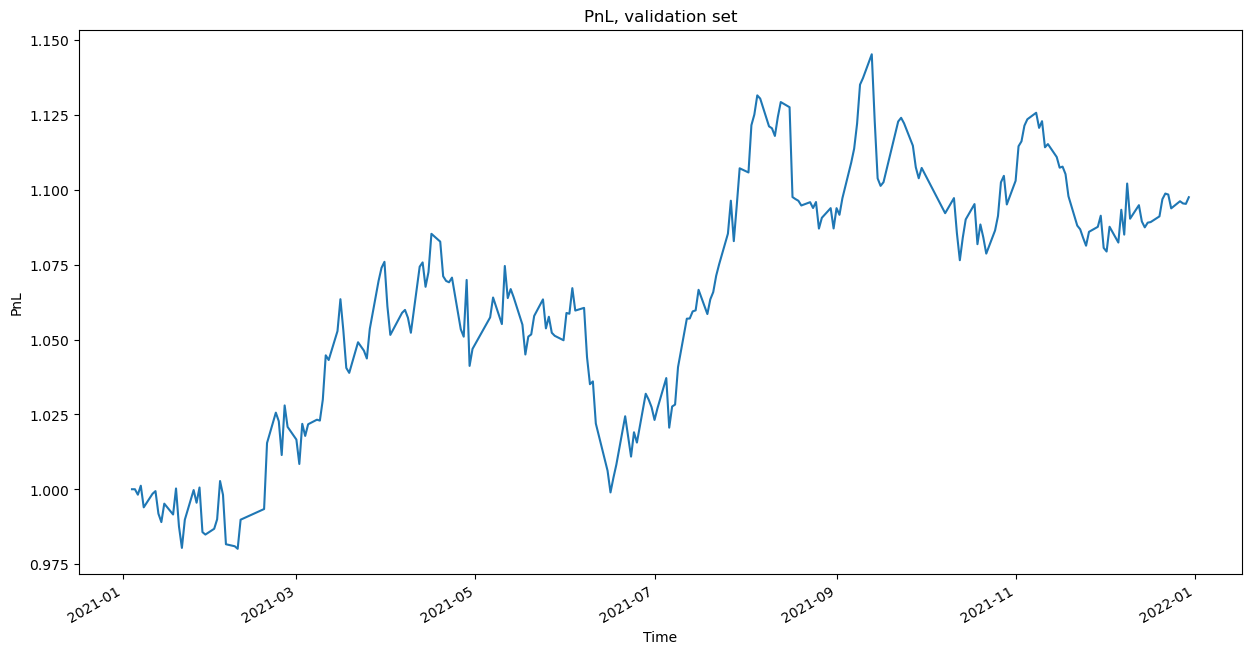

In [58]:
pnl = simulate(p, sma_signal, 2428, 2670)
pnl.plot(figsize=(15,8), title='PnL, validation set', xlabel='Time', ylabel='PnL');

Sharpe ratio on validation set

In [59]:
pnl.pct_change().mean() / pnl.pct_change().std()

0.051597635968923486

In [60]:
N = 30
test_p = p['2021-01-04':]

sma = np.zeros(len(test_p))

for i in range(len(sma)):
    sma[i] = SMA(test_p, i, N)
    
sma = pd.Series(sma, index = test_p.index)

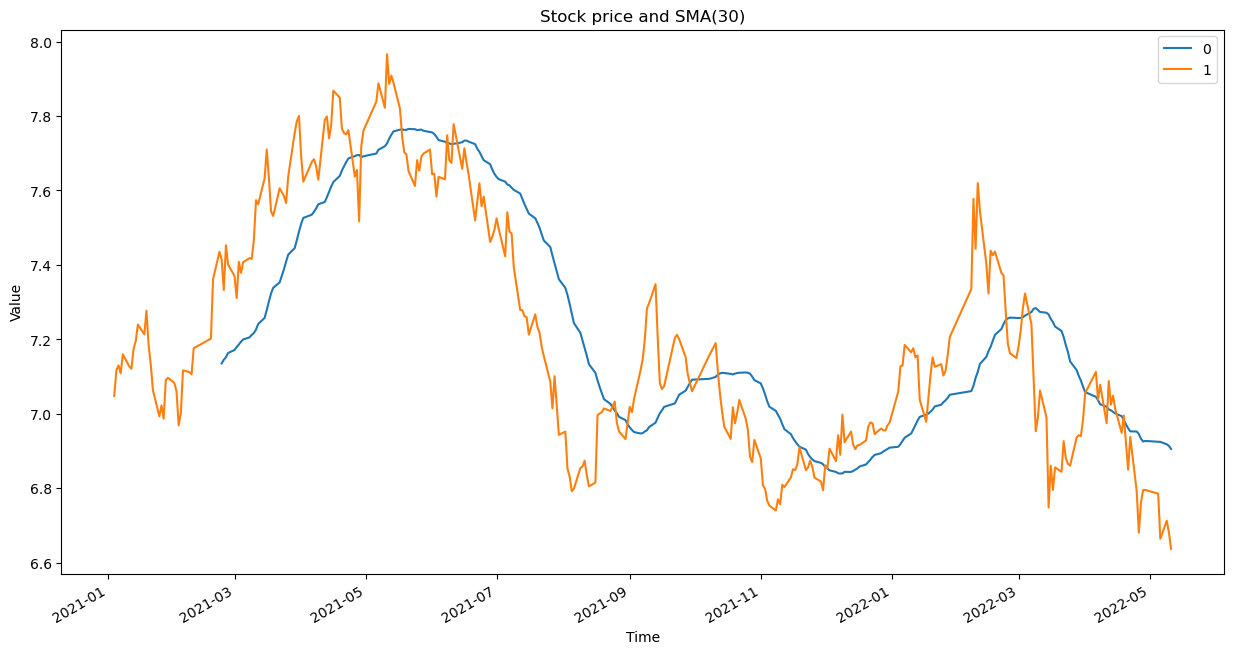

In [61]:
pd.concat([sma,test_p],axis=1).plot(figsize=(15,8), title='Stock price and SMA(30)', xlabel='Time', ylabel='Value');

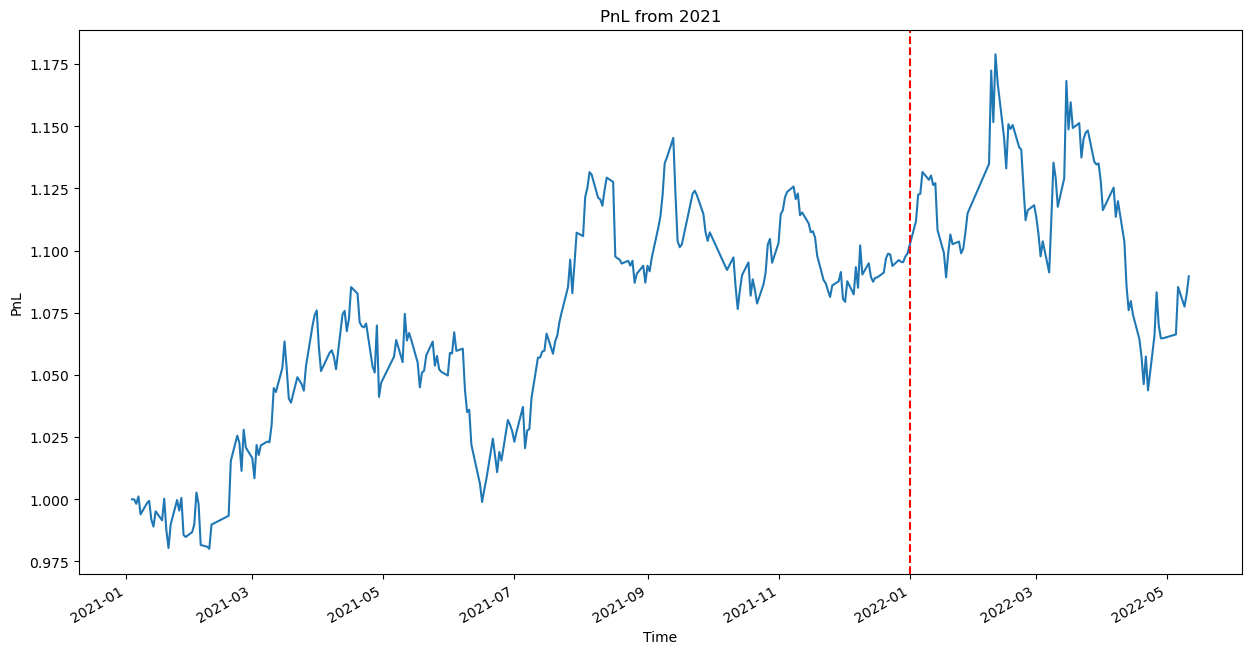

In [62]:
pnl = simulate(p, sma_signal, 2428, 2753)
pnl.plot(figsize=(15,8), title='PnL from 2021', xlabel='Time', ylabel='PnL')
plt.axvline("2022-01-01", color="red", linestyle="--")
plt.show()

Sharpe's ratio

In [63]:
pnl = pnl['2022-01-04':] / pnl['2022-01-04']

In [64]:
pnl.pct_change().mean() / pnl.pct_change().std()

-0.016246144917386813

Return Over Maximum Drawdown:

In [65]:
max_ret = pnl.max()
max_ret # 2022-02-10
min_val = pnl['2022-02-10':].min()
max_draw = (max_ret - min_val) / max_ret * 100
print('Maximum Drawdown: ', max_draw,'%')
coef = 100*(pnl[-1]-1) / max_draw
print('Return Over Maximum Drawdown:: ',coef)

Maximum Drawdown:  11.463898329115656 %
Return Over Maximum Drawdown::  -0.1743903347261802


#### Test set

In [66]:
pnl = simulate(p, sma_signal, 2428, 2670)

In [67]:
max_ret = pnl.max() # 2021-09-13

In [68]:
min_val = pnl['2021-09-13':].min()
min_val

1.0765041713376005

In [69]:
max_draw = (max_ret - min_val) / max_ret * 100
print('Maximum drawdown: ',max_draw,'%')

Maximum drawdown:  6.0068320838411315 %


In [70]:
coef = 100*(pnl[-1]-1) / max_draw
print('Return Over Maximum Drawdown:: ',coef)

Return Over Maximum Drawdown::  1.6239603727907226
